lorenz 96 de la clase del profe Nino Ruiz

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy as sci
from sklearn.model_selection import train_test_split
import scipy as sci
#import seaborn as sns
#y = [x, y, z]

nvars = 8

def lorenz96(t, y):
    return [(y[(i+1) % nvars] - y[(i-2) % nvars]) * y[(i-1) % nvars] - y[i] + 8 for i in range(nvars)]

Funcion para plotear la evolucion de una variable del lorenz

In [11]:

import matplotlib.pyplot as plt
import numpy as np

def plot_lorenz96_variable(sol_object, variable_index):
  """
  Grafica una variable específica del modelo de Lorenz 96 a lo largo del tiempo.

  Args:
    sol_object (scipy.integrate.OdeSolution): El objeto de solución
      devuelto por solve_ivp.
    variable_index (int): El índice de la variable a graficar (de 0 a 39).
  """
  # Extraer los tiempos y las variables de la solución
  times = sol_object.t
  y_values = sol_object.y

  # Seleccionar la variable específica para graficar
  if variable_index < 0 or variable_index >= y_values.shape[0]:
    raise IndexError("El índice de la variable debe estar entre 0 y 39.")

  variable_to_plot = y_values[variable_index, :]

  #  figura y los ejes
  plt.figure(figsize=(10, 6))
  plt.plot(times, variable_to_plot)
  plt.title(f'Evolución $y_{{{variable_index}}}$ del Lorenz 96')
  plt.xlabel('Tiempo')
  plt.ylabel(f'Valor de la variable $y_{{{variable_index}}}$')
  plt.grid(True)
  plt.show()


def plot_ensemble_evolution(y_truth, eb, variable_index):
  """
  Grafica la evolución de una variable específica de la "verdad" y
  de todos los miembros del ensamble.

  Args:
    y_truth (np.array): La matriz de la trayectoria de verdad (n_vars x n_time).
    eb (list): La lista de matrices de trayectorias del ensamble.
    variable_index (int): El índice de la variable a graficar.
  """
  # Verificar que el índice de la variable sea válido
  if variable_index < 0 or variable_index >= y_truth.shape[0]:
    raise IndexError(f"El índice de la variable debe estar entre 0 y {y_truth.shape[0]-1}.")

  # Extraer los tiempos de la primera trayectoria del ensamble
  # (asumimos que todas tienen los mismos tiempos)
  time_steps = np.arange(y_truth.shape[1]) * 0.005 # Ajustar al paso de tiempo
  
  plt.figure(figsize=(12, 7))

  # 1. Graficar la trayectoria de verdad en rojo
  plt.plot(time_steps, y_truth[variable_index, :], label='Verdad', color='red', linewidth=2)

  # 2. Graficar cada miembro del ensamble en gris claro
  for i, ensemble_member_trajectory in enumerate(eb):
    plt.plot(time_steps, ensemble_member_trajectory[variable_index, :], color='lightgray', alpha=0.7)

  # Para que la leyenda del ensamble no se duplique 20 veces,
  # graficamos uno solo con el label
  plt.plot([], [], color='lightgray', label='Miembros del ensamble')

  # Añadir etiquetas, título y leyenda
  plt.title(f'Evolución de la variable ${variable_index}$ - Verdad vs. Ensamble')
  plt.xlabel('Tiempo')
  plt.ylabel(f'Valor de la variable ${variable_index}$')
  plt.legend()
  plt.grid(True)
  plt.show()


definicion de las condiciones iniciales

In [12]:

np.random.seed(10);

t0 = 0;
tf = 10;
t = np.arange(t0, tf, 0.005);
print("Numero de tiempos :",t.shape)

Numero de tiempos : (2000,)


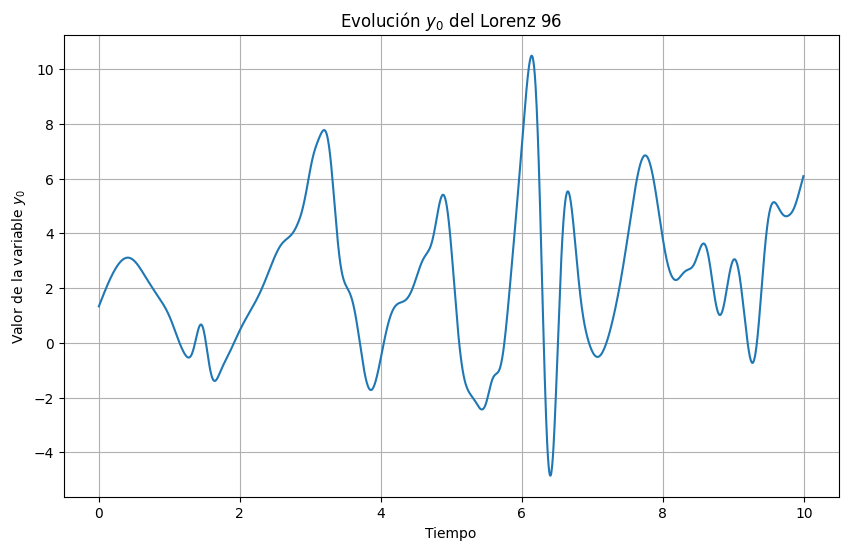

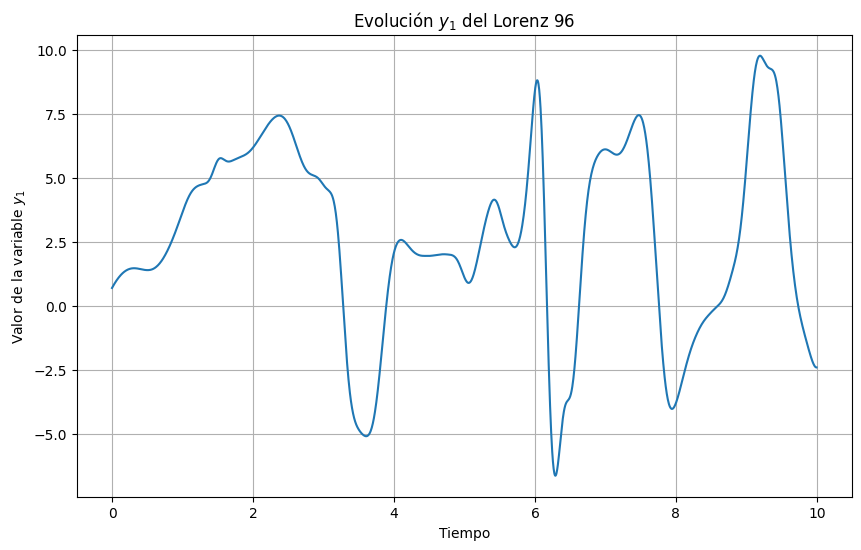

In [13]:

sol = solve_ivp(lorenz96, [t0, tf], np.random.randn(nvars), t_eval=t);
y = sol.y;

#Depues tenemos que cambiar este rango para la entrega
for i in range(0,2):
  plot_lorenz96_variable(sol, i)

${\bf X}^a ={\bf X}^b + [{\bf P}^{b{-1}} + {\bf H}^T {\bf R}^{-1} {\bf H}]^{-1} {\bf H}^T {\bf R}^{-1} \left[ {\bf Y}^{S} - {\bf H} {\bf X}^b \right ]$

In [14]:
def compute_analysis_enkf_model(XB, PB, H, Ys, R):
  #MODELO CON 3D-VAr
  PB_inv = np.linalg.inv(PB); #NO hacer en casa
  R_inv = np.linalg.inv(R); #NO hacer en casa
  Ds = H.T @ R_inv @ (Ys - H @ XB);
  PA_inv = PB_inv + H.T @ R_inv @ H;
  DXa = np.linalg.solve(PA_inv, Ds);
  XA = XB + DXa;
  return XA;

def get_syn_observations(y, m, Nens, R):
  white_noise = np.random.multivariate_normal(np.zeros(m), R, size=Nens).T;
  Ys = y + white_noise;
  return Ys;

In [15]:
def perform_forecast(x, t0, tf):
  sol = solve_ivp(lorenz96, [t0, tf], x);
  return sol.y[:,-1];

def get_random_H(p, n):
  indexes = np.arange(0,n);
  ind,_ = train_test_split(indexes, random_state=10, test_size=1-p)
  ind.sort();
  ind = ind.astype(np.int32);
  m = ind.size
  H = np.eye(n,n);
  H = H[ind,:];
  return H;

MODELADO DE LOS MULTIPLES MIEMBROS DEL ENSAMBLE

In [16]:


#condiciones iniciales
ic = y[:,-1];
#tamaño del ensamble
Nens = 20;
#ruido aleatorio 
white_noise = np.random.randn(Nens,nvars);
#ruido aleatorio agredado a los miembros del ensamble

e_0 = ic + 0.05 * white_noise; #perturbed ensemble
print(e_0.shape)
eb = [];
t0 = 0;
tf = 10;
t = np.arange(t0, tf, 0.005);
for e in e_0:

  sol = solve_ivp(lorenz96, [t0, tf], e, t_eval=t);
  eb.append(sol.y);
  #len=20 miembros del nesamble, con shape (8,2000) por ser 8 variables analizadas y 2000 tiempos




(20, 8)


ciclos de asimilacion

In [17]:

n = 8#40;
p = 0.8;
m = round(n*p)
Nens = 20;
R = np.diag(0.01**2 * np.ones(m));
M = 15;


#reference solution
xref = ic;

#initial ensemble
XB = [e[:,-1] for e in eb]
XB = np.array(XB, dtype=np.float32).T;
#XB = e_0.T
era = np.zeros(M);
erb = np.zeros(M);

for k in range(0, M):
  #forecast for the reference solution (for reference)
  xref = perform_forecast(xref, 0, 0.05);

  #forecast step (background step)
  for e in range(0,Nens):
    XB[:,e] = perform_forecast(XB[:,e], 0, 0.05);

  #Forecast
  PB = np.cov(XB);

  #get the observation
  H = get_random_H(p, n);
  
  y = H @ xref.reshape(-1,1) + np.random.multivariate_normal(np.zeros(m), R).reshape(-1,1);
  Ys = get_syn_observations(y, m, Nens, R);

  #analysis step
  
  XA = compute_analysis_enkf_model(XB, PB, H, Ys, R);
  
  #assesing accuracies via the prior and the posterior first moments
  xb = np.mean(XB, axis=1);
  xa = np.mean(XA, axis=1);

  #L-2 norm of errors
  erb[k] = np.linalg.norm(xb-xref);
  era[k] = np.linalg.norm(xa-xref);

  XB = XA;

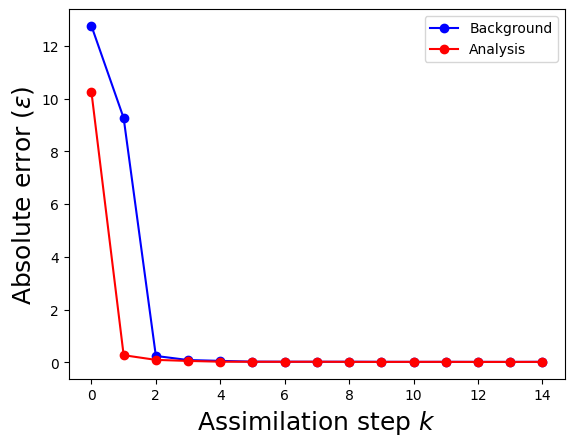

In [18]:
plt.plot(erb, '-ob');
plt.plot(era, '-or');
plt.xlabel('Assimilation step $k$', fontdict={'size':18});
plt.ylabel('Absolute error ($\epsilon$)', fontdict={'size':18});
plt.legend(['Background', 'Analysis'])